In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches

In [2]:
ds_esm2m = xr.open_dataset('../data/processed/GFDL/hottestmonth_toes.nc')
ds_cesm2 = xr.open_dataset('../data/processed/CESM2/hottestmonth_toes.nc')

In [24]:
range_esm2m = ds_esm2m.quantile(0.9,'ensemble') - ds_esm2m.quantile(0.1,'ensemble')
range_cesm2 = ds_cesm2.quantile(0.9,'ensemble') - ds_cesm2.quantile(0.1,'ensemble')

In [40]:
lat_esm2m_25 = range_esm2m['0.75'].where(range_esm2m['0.75']>0).mean('lon',skipna=True)
lat_esm2m_50 = range_esm2m['0.5'].where(range_esm2m['0.5']>0).mean('lon',skipna=True)

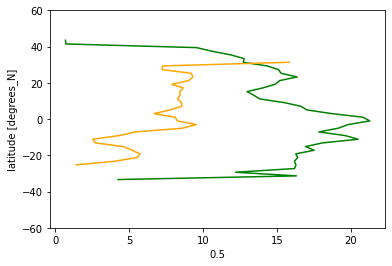

In [46]:
fig,ax=plt.subplots()
lat_esm2m_25.plot(ax=ax,y='lat',ylim=[-60,60],color='green')
lat_esm2m_50.plot(ax=ax,y='lat',ylim=[-60,60],color='orange')

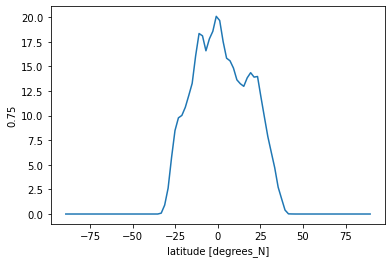

In [30]:
range_esm2m['0.75'].mean('lon').plot()

In [47]:
range(0,30,10)

range(0, 30, 10)